### 흥행 점수 계산

#### 0. 주요 파일 로드 및 준비

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [69]:
movies = pd.read_parquet('files/final_files/00_movie_main.parquet')
movies = movies.dropna(subset = ['imdb_rating'])
movie_finance = pd.read_parquet('files/final_files/01_movie_finance.parquet')

In [70]:
test_df = movies.copy()

#### 1. 평점 안정화

평점은 영화의 가치를 평가하는 주요 지표지만, 평점수가 적어도 평점이 높가 나오는 등의 문제가 있다. 따라서 평점을 안정화하여야 좋은 지표로 활용할 수 있다. 우선 IMDb에서 사용하는 weighted_rating를 게산하여 안정화된 평점을 산출하였다.

In [71]:
# 전체 평점 통합
test_df = test_df.assign(
    rating = ((test_df['tmdb_rating'] * test_df['tmdb_num_votes']) +
            (test_df['imdb_rating'] * test_df['imdb_num_votes']))/
            (test_df['imdb_num_votes'] + test_df['tmdb_num_votes'])
)

# 보조 지표 계산
test_df = test_df.assign(num_votes = (test_df['imdb_num_votes'] + test_df['tmdb_num_votes']))
rating_avg = (test_df['num_votes'] * test_df['imdb_rating']).sum() / test_df['num_votes'].sum()
min_vote = np.quantile(test_df['num_votes'], q=0.2)

# 최종 weighted_ratin 계산
test_df = test_df.assign(
    weighted_rating = (test_df['num_votes'] / (test_df['num_votes'] + min_vote)) *test_df['rating'] +
                    (min_vote / (test_df['num_votes'] + min_vote)) * rating_avg
)

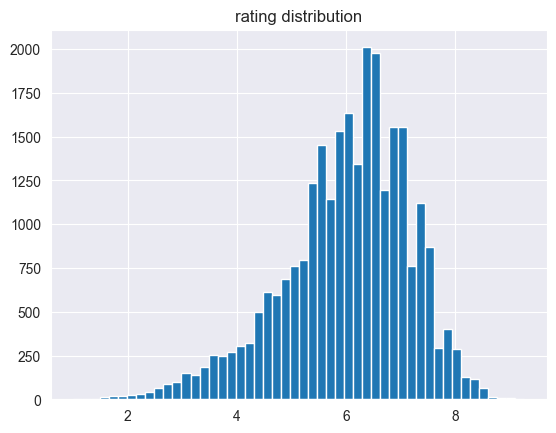

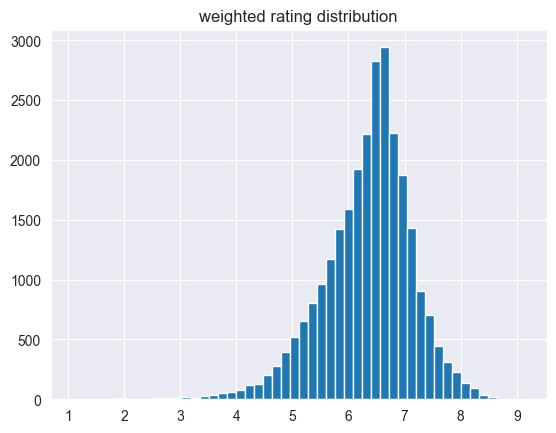

In [72]:
#  평점 분포
test_df['rating'].hist(bins= 50)
plt.title('rating distribution')
plt.show()

# 안정된 평점 분포
test_df['weighted_rating'].hist(bins= 50)
plt.title('weighted rating distribution')
plt.show()

두 평점의 분포를 보면 안정된 평점에서 전체 평점이 평균으로 회귀하는 모습을 볼 수 있다. 이러면 상위에서 적은 평점 수를 가진 영화들의 평점을 조정할 수 있다. 그런데 이런 방식의 문제점은 평점수가 적은데 평점이 낮은 소위 문제작들을 평균으로 회귀시켜버린다는 문제가 있다. 따라서 이를 보정하여야 이 점수를 원활하게 사용할 수 있다. 이를 위해 선형 보간을 통해서 낮은 평점에서 일반 평점을 더 많이 반영하고, 높은 평점에서는 안정된 평점을 반영하도록 두 평점을 결합하였다.

In [73]:
alpha = 0.2 + 0.6 * ((test_df['rating'] - 1) / (10 - 1))
test_df = test_df.assign(adjust_rating=test_df['weighted_rating'] * alpha + test_df['rating'] * (1 - alpha))

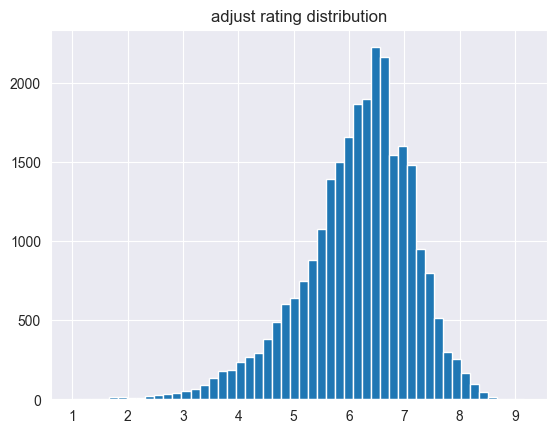

In [74]:
# 최종 평점 분포
test_df['adjust_rating'].hist(bins= 50)
plt.title('adjust rating distribution')
plt.show()

조정된 평점은 일반 평점과 안정화된 평점의 중간 형태를 하고 있으면서 더 안정된 그래프를 보인다. 따라서 이 평점을 최종적으로 사용할 평점으로 결정하였다.

#### 2. 로그 변환 및 스케일링

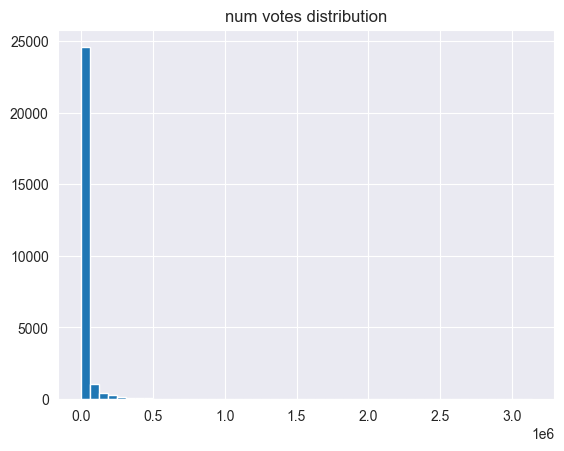

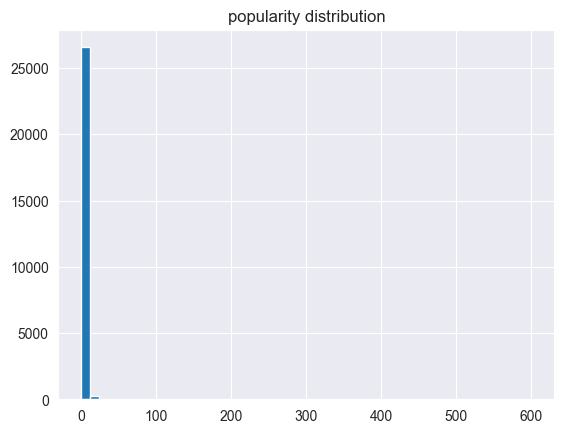

In [75]:
# 평점수 분포
test_df['num_votes'].hist(bins= 50)
plt.title('num votes distribution')
plt.show()

# 화제성 분포
test_df['popularity'].hist(bins= 50)
plt.title('popularity distribution')
plt.show()

화제성과 평점수는 현제 화제성과 누적 평점수를 가르키는 지표로 극단적인 긴꼬리 분포를 하고 있다. 이를 활용하기 위해서는 로그 변환을 통해 안정화 시킬 필요가 있다. 최종 점수 산출을 위해서는 스케일링을 진행해주어야 하지만 최솟값과 최댓값을 스케일링에 사용할 경우 데이터 누수 문제가 있을수도 있기에 고정값을 통한 스케일링을 진행하였다. 이때 고정값은 전체 범위에서 20%더 넓은 범위를 가지는 정수로 설정하였다.

In [76]:
def scaler(data, column, min_val, max_val):
    data[f"{column}_scaled"] = (
            (np.log(data[column]) - min_val) / (max_val - min_val)
    ).clip(0, 1)
    return data

def num_votes_scaler(data, min_val = 1, max_val = 17):
    return scaler(data, 'num_votes', min_val, max_val)

def popularity_scaler(data, min_val = -6, max_val = 8):
    return scaler(data, 'popularity', min_val, max_val)

def adjust_rating_scaler(data, min_val = 1, max_val = 10):
    column = 'adjust_rating'
    data[f"{column}_scaled"] = (
            (data[column] - min_val) / (max_val - min_val)
    ).clip(0, 1)
    return data

In [77]:
test_df = num_votes_scaler(test_df)
test_df = popularity_scaler(test_df)
test_df = adjust_rating_scaler(test_df)

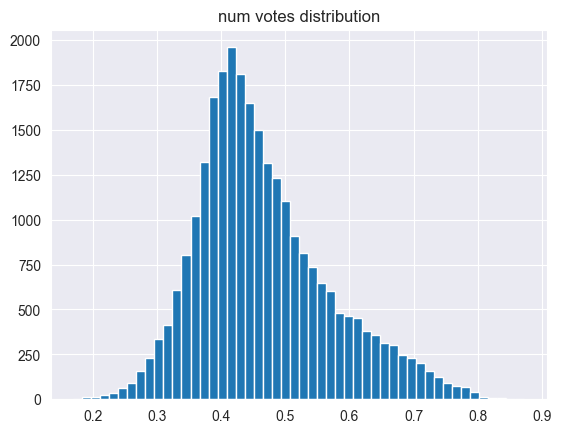

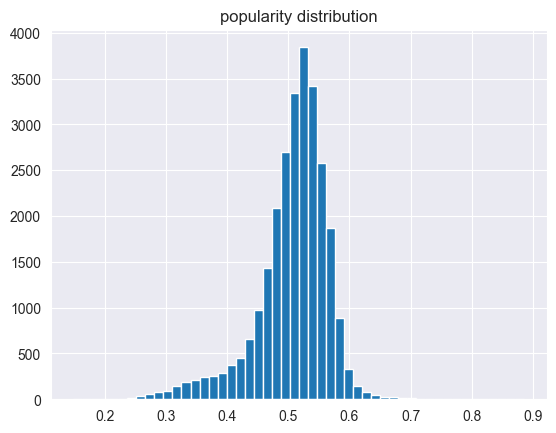

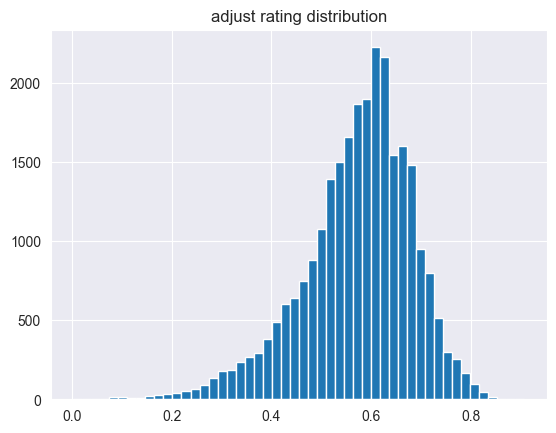

In [78]:
# 평점수 분포
test_df['num_votes_scaled'].hist(bins= 50)
plt.title('num votes distribution')
plt.show()

# 화제성 분포
test_df['popularity_scaled'].hist(bins= 50)
plt.title('popularity distribution')
plt.show()

# 평점 분포
test_df['adjust_rating_scaled'].hist(bins= 50)
plt.title('adjust rating distribution')
plt.show()

#### 3. 결합 가중치 설정

In [79]:
test_finance = movie_finance.assign(roi = (movie_finance['revenue'] - movie_finance['budget']) / movie_finance['budget'])
linea_test_df = pd.merge(test_finance, test_df, on = 'id', how = 'inner')[['roi', 'num_votes_scaled', 'popularity_scaled', 'adjust_rating_scaled']]
X = linea_test_df[['num_votes_scaled', 'adjust_rating_scaled']]
y = (np.log1p(linea_test_df['roi']) - (np.log1p(linea_test_df['roi'])).min()) / (np.log1p(linea_test_df['roi']).max() - (np.log1p(linea_test_df['roi'])).min())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [80]:
def check_multicollinearity(X):
    """
    VIF(Variance Inflation Factor) 계산
    VIF > 10: 심각한 다중공선성
    VIF > 5: 주의 필요
    """
    vif_data = pd.DataFrame()
    vif_data["Variable"] = ['num_votes_scaled', 'adjust_rating_scaled']
    vif_data["VIF"] = [
        variance_inflation_factor(X, i) for i in range(X.shape[1])
    ]

    print("=== 다중공선성 검사 (VIF) ===")
    print(vif_data)
    print("\n해석:")
    print("VIF < 5: 문제 없음")
    print("VIF 5~10: 주의")
    print("VIF > 10: 심각 (변수 제거 필요)")

    return vif_data

# 실행
vif = check_multicollinearity(X)

=== 다중공선성 검사 (VIF) ===
               Variable        VIF
0      num_votes_scaled  24.397053
1  adjust_rating_scaled  24.397053

해석:
VIF < 5: 문제 없음
VIF 5~10: 주의
VIF > 10: 심각 (변수 제거 필요)


In [81]:
liner = LinearRegression()
liner.fit(X_train, y_train)
pred_liner = liner.predict(X_test)

print(f"R2   : {r2_score(y_test, pred_liner):.3f}")
print(f"RMSE : {root_mean_squared_error(y_test, pred_liner):.2f}")
print(f"MAE  : {mean_absolute_error(y_test, pred_liner):.2f}")

print(f"num_votes_scaled : {((liner.coef_ / (liner.coef_).sum()) * 0.9)[0]}")
print(f"adjust_rating_scaled : {((liner.coef_ / (liner.coef_).sum()) * 0.9)[1]}")

R2   : 0.171
RMSE : 0.06
MAE  : 0.04
num_votes_scaled : 0.6380939603619843
adjust_rating_scaled : 0.26190603963801573


다중공산성 문제와 부족한 결정계수 문제가 있으나 가중치를 계산하기 위한 분석이므로 무시하고 회귀계수를 가중치로 설정하였다. 이를 가중치로 벡터 결합하여 최종적인 정량 흥행 점수를 계산하였다.

#### 4. 최종 흥행 점수 계산

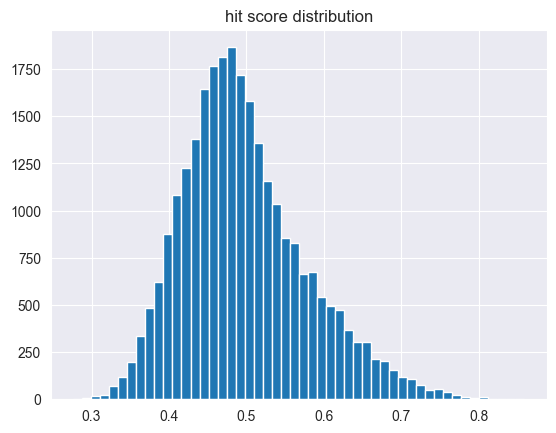

In [84]:
qn_hit_score = (
    (test_df["num_votes_scaled"] * 0.6380939603619843) +
    (test_df["popularity_scaled"] * 0.1) +
    (test_df["adjust_rating_scaled"] * 0.26190603963801573)
)
qn_hit_score.hist(bins= 50)
plt.title('hit score distribution')
plt.show()

#### 5. 최종 함수 도출

In [83]:
def scaler(data, column, min_val, max_val):
    data[f"{column}_scaled"] = (
            (np.log(data[column]) - min_val) / (max_val - min_val)
    ).clip(0, 1)
    return data

def num_votes_scaler(data, min_val = 1, max_val = 17):
    return scaler(data, 'num_votes', min_val, max_val)

def popularity_scaler(data, min_val = -6, max_val = 8):
    return scaler(data, 'popularity', min_val, max_val)

def adjust_rating_scaler(data, min_val = 1, max_val = 10):
    column = 'adjust_rating'
    data[f"{column}_scaled"] = (
            (data[column] - min_val) / (max_val - min_val)
    ).clip(0, 1)
    return data

def cal_qn_hit_score(data, min_ratio = 0.2):
    W_VOTES = 0.6380939603619843
    W_POP = 0.1
    W_RATING = 0.26190603963801573

    # 가중 평균으로 두 데이터를 통합
    data = data.assign(
        rating = ((data['tmdb_rating'] * data['tmdb_num_votes']) +
                  (data['imdb_rating'] * data['imdb_num_votes']))/
                 (data['imdb_num_votes'] + data['tmdb_num_votes'])
    )

    # 보조 지표들 산출
    data = data.assign(num_votes = (data['imdb_num_votes'] + data['tmdb_num_votes']))
    rating_avg = (data['num_votes'] * data['imdb_rating']).sum() / data['num_votes'].sum()
    min_vote = np.quantile(data['num_votes'], q=min_ratio)

    # 최종 weighted_ratin 계산
    data = data.assign(
        weighted_rating = (data['num_votes'] / (data['num_votes'] + min_vote)) *data['rating'] +
                        (min_vote / (data['num_votes'] + min_vote)) * rating_avg
    )

    alpha = 0.2 + 0.6 * ((data['rating'] - 1) / (10 - 1))
    data = data.assign(adjust_rating=data['weighted_rating'] * alpha + data['rating'] * (1 - alpha))

    data = num_votes_scaler(data)
    data = popularity_scaler(data)
    data = adjust_rating_scaler(data)

    qn_hit_score = (
        (data["num_votes_scaled"] * W_VOTES) +
        (data["popularity_scaled"] * W_POP) +
        (data["adjust_rating_scaled"] * W_RATING)
    )

    return qn_hit_score